In [1]:
import h5py

h5filename = '/data1/public/vqhlm/wikitext103_gpt2finetuned/test.h5'

# 数据操作

## ChunkedDataset

In [2]:
from dataloading import get_chunked_h5dataloader
from constants import KEY_LM_INPUT_IDS, KEY_LM_HIDDEN_STATES, KEY_LM_LABELS

dataloader = get_chunked_h5dataloader(
    config_path='conf/data/example.yaml',
    split='test',
)

for batch in dataloader:
    input_ids = batch[KEY_LM_INPUT_IDS]
    labels = batch[KEY_LM_LABELS]
    hidden_states = batch[KEY_LM_HIDDEN_STATES]
    
    print(f"Input IDs: {input_ids.shape}")
    print(f"Labels: {labels.shape}")
    print(f"Hidden States: {hidden_states.shape}")
    break  # 这里只打印一个批次的数据

Input IDs: torch.Size([128, 1024])
Labels: torch.Size([128, 1024])
Hidden States: torch.Size([128, 256, 768])


## 线性缩放计算Loss估计值

In [3]:
def calculate_dataset_stats(dataloader, ratio=0.7):
    total_loss = 0
    # 遍历整个数据集并收集所有的 hidden_states
    for i, batch in enumerate(dataloader):
        hidden_states = batch[KEY_LM_HIDDEN_STATES]
        out = ratio * hidden_states
        # out = out.clamp(-1., 1.)
        rec_loss = (out - hidden_states).abs().mean()
        total_loss += rec_loss.item()
    total_loss /= len(dataloader)
    return total_loss    

# # 示例用法：
for ratio in range(60, 100, 2):
    ratio = 0.01*ratio
    total_loss = calculate_dataset_stats(dataloader, ratio)
    print("%.2f"%(ratio), f":{total_loss}")

0.60 :0.8160842776298523
0.62 :0.7752801060676575
0.64 :0.7344759583473206
0.66 :0.6936716437339783
0.68 :0.6528674244880677
0.70 :0.6120632886886597
0.72 :0.5712589859962464
0.74 :0.5304548025131226
0.76 :0.4896506190299988
0.78 :0.448846435546875
0.80 :0.4080421268939972
0.82 :0.3672379791736603
0.84 :0.32643377780914307
0.86 :0.2856294929981232
0.88 :0.2448253095149994
0.90 :0.20402113497257232
0.92 :0.16321683526039124
0.94 :0.1224126547574997
0.96 :0.0816084772348404
0.98 :0.040804176777601245


## 高斯分布计算Loss估计值

In [5]:
import torch

def calculate_dataset_stats(dataloader, ratio=0.7):
    total_loss = 0
    # 遍历整个数据集并收集所有的 hidden_states
    for i, batch in enumerate(dataloader):
        hidden_states = batch[KEY_LM_HIDDEN_STATES]
        
        # 创建一个形状为 (256,) 的掩码，标记出比例为 (1-ratio) 的部分
        mask = torch.rand(hidden_states.size(1)) < ratio  # mask的大小是 (256,)
        
        # 扩展掩码到 (128, 256, 768) 形状
        mask = mask.unsqueeze(0).unsqueeze(2).expand(hidden_states.size(0), hidden_states.size(1), hidden_states.size(2))
        
        # 生成一个形状与 hidden_states 相同的高斯分布张量
        gaussian_fill = torch.normal(mean=hidden_states.mean(), std=hidden_states.std())  # 生成均值为0，方差为1的高斯分布
        
        # 将被掩盖为零的部分用高斯分布填充
        masked_hidden_states = hidden_states * mask.float() + gaussian_fill * (1 - mask.float())
        
        # 计算重构损失
        rec_loss = (masked_hidden_states - hidden_states).abs().mean()
        total_loss += rec_loss.item()

    total_loss /= len(dataloader)
    return total_loss

for ratio in range(60, 100, 2):
    ratio = 0.01*ratio
    total_loss = calculate_dataset_stats(dataloader, ratio)
    print("%.2f"%(ratio), f":{total_loss}")

0.60 :1.33099684715271
0.62 :1.0340008735656738
0.64 :1.2303516507148742
0.66 :1.0754451632499695
0.68 :0.6998544454574585
0.70 :0.8215419173240661
0.72 :0.9158506155014038
0.74 :0.814272403717041
0.76 :0.8195157647132874
0.78 :0.7020301461219788
0.80 :0.8077657759189606
0.82 :0.5790830552577972
0.84 :0.4984911382198334
0.86 :0.503730633854866
0.88 :0.3759007602930069
0.90 :0.4350153267383575
0.92 :0.27799751460552213
0.94 :0.18833388537168502
0.96 :0.1073386013507843
0.98 :0.04887363277375698


## H5py直接操作

- 模型来自 https://huggingface.co/neulab/gpt2-finetuned-wikitext103
- 模型tokenizer和定义如下
```
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("neulab/gpt2-finetuned-wikitext103")
model = AutoModelForCausalLM.from_pretrained("neulab/gpt2-finetuned-wikitext103")
```

In [3]:
# 读取 HDF5 文件
with h5py.File(h5filename, 'r') as f:
    # 读取 total_samples 元数据
    total_samples = f.attrs['total_samples']
    print(f"Total samples in the dataset: {total_samples}")
    
    # 读取数据集
    hidden_states = f['hidden_states'][:]
    input_ids = f['input_ids'][:]
    labels = f['labels'][:]

    # 打印数据集的形状，确保读取正确
    print(f"Hidden states shape: {hidden_states.shape}")
    print(f"Input IDs shape: {input_ids.shape}")
    print(f"Labels shape: {labels.shape}")
    
    # 获取第一个样本的数据并展示
    sample_idx = 0  # 举例，读取第一个样本
    print(f"Sample {sample_idx} - Input IDs: {input_ids[sample_idx]}")
    print(f"Sample {sample_idx} - Labels: {labels[sample_idx]}")
    
    # 获取对应的 hidden states (flattened)
    print(f"Sample {sample_idx} - Hidden States: {hidden_states[sample_idx]}")

Total samples in the dataset: 548
Hidden states shape: (548, 1024, 768)
Input IDs shape: (548, 1024)
Labels shape: (548, 1024)
Sample 0 - Input IDs: [  796  5199   347 ... 50256 50256 50256]
Sample 0 - Labels: [ 796 5199  347 ... -100 -100 -100]
Sample 0 - Hidden States: [[-1.6174933  -1.1284641   0.0215988  ... -2.2583933   1.6741287
  -0.35499385]
 [-5.498198    2.3329258  -2.2865224  ...  0.42031875  0.07713613
   1.1435596 ]
 [ 1.8659987   1.5455958   1.0896978  ...  3.514292   -0.08421862
   3.3854916 ]
 ...
 [ 0.798916    2.5979886  -0.07587534 ... -0.737859   -1.1983643
   4.190173  ]
 [ 0.7338563   2.760131   -0.01490831 ... -0.6301186  -1.1114419
   4.6592402 ]
 [ 0.7557825   1.4493941  -3.1341372  ... -2.043258    0.9624741
   5.8210287 ]]


## 预览index frequencies（需要已经跑完test）

Data loaded from CSV: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 4, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5, 16: 5, 17: 5, 18: 5, 19: 5, 20: 5, 21: 5, 22: 3, 23: 5, 24: 5, 25: 5, 26: 5, 27: 4, 28: 5, 29: 5, 30: 5, 31: 5, 32: 5, 33: 4, 34: 5, 35: 5, 36: 5, 37: 5, 38: 5, 39: 5, 40: 4, 41: 4, 42: 5, 43: 5, 44: 5, 45: 5, 46: 5, 47: 4, 48: 3, 49: 5, 50: 5, 51: 5, 52: 5, 53: 5, 54: 5, 55: 5, 56: 5, 57: 5, 58: 5, 59: 5, 60: 5, 61: 5, 62: 5, 63: 5, 64: 5, 65: 5, 66: 5, 67: 5, 68: 5, 69: 5, 70: 5, 71: 5, 72: 5, 73: 5, 74: 5, 75: 5, 76: 5, 77: 5, 78: 5, 79: 5, 80: 5, 81: 5, 82: 5, 83: 5, 84: 5, 85: 5, 86: 5, 87: 5, 88: 5, 89: 5, 90: 5, 91: 5, 92: 5, 93: 5, 94: 5, 95: 5, 96: 5, 97: 5, 98: 5, 99: 5, 100: 5, 101: 5, 102: 5, 103: 5, 104: 5, 105: 5, 106: 5, 107: 5, 108: 5, 109: 5, 110: 5, 111: 5, 112: 5, 113: 5, 114: 4, 115: 5, 116: 5, 117: 5, 118: 5, 119: 5, 120: 5, 121: 5, 122: 5, 123: 5, 124: 5, 125: 5, 126: 5, 127: 4, 128: 5, 129: 5, 130: 5, 131: 5, 132: 5, 133: 5, 134: 5, 135: 5,

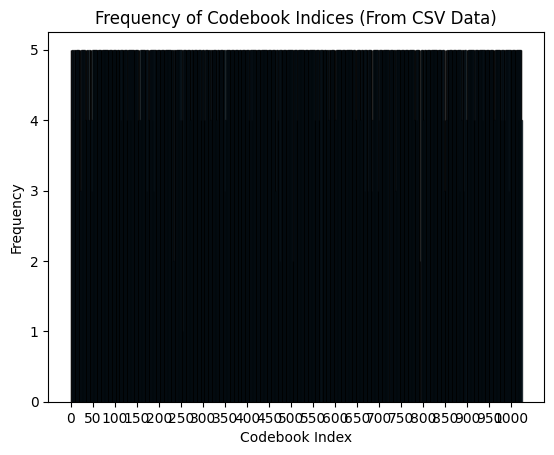

In [6]:
import csv

# 读取CSV文件并加载到字典中
index_count_from_csv = {}

with open('runs/vq_vanilla/index_frequencies.csv', mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # 跳过表头
    for row in reader:
        index = int(row[0])
        frequency = int(row[1])
        index_count_from_csv[index] = frequency

print("Data loaded from CSV:", index_count_from_csv)
import matplotlib.pyplot as plt

# 提取所有索引的出现次数
frequencies_from_csv = list(index_count_from_csv.values())

# 绘制直方图
plt.bar(range(len(frequencies_from_csv)), frequencies_from_csv, edgecolor='black', alpha=0.7)
plt.title("Frequency of Codebook Indices (From CSV Data)")
plt.xlabel("Codebook Index")
plt.ylabel("Frequency")
plt.xticks(range(0, len(frequencies_from_csv), 50))  # 可调整间隔，防止标签过密
plt.show()
